# TimeSeries - Prevendo a venda de vinhos

<img src="https://i.imgur.com/mFyEM4N.jpg" />

## Nesse projeto irei reproduzir uma previsão de vendas de vinhos para o ano de 1973.

### Usando o clássico Data Set da Famille Perrin uma vinicola da cidade de Rhône na França.

crédito: https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/;
https://github.com/krishnaik06

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline



import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 999)

In [2]:
%time data = pd.read_csv('C:/Users/skite/OneDrive/Documentos/GitHub/Projeto_TimeSeries_Vinho/perrin-freres-monthly-champagne-.csv', sep = ',', encoding  = 'ISO-8859-1')

Wall time: 25 ms


# Análise exploratória dos dados

In [3]:
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


*Limpeza dos dados:vamos renomear as colunas*

In [6]:
data.columns=["Mes","Vendas"]
data.head()

,Mes,Vendas
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [7]:
data.tail()

,Mes,Vendas
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


*Vamos dropar as duas ultimas linhas, pois estão nulas*

In [8]:
data.drop(105,axis=0,inplace=True)
data.drop(106,axis=0,inplace=True)

In [9]:
data.tail()

,Mes,Vendas
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mes     105 non-null    object 
 1   Vendas  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


**Esse DataSet é bem simple e fácil de ser compreendido, logo já temos os dados pronto para ajuste**

## Conversão dos dados do mês para datetime.

*Para aplicar o ARIMA e Seasonal ARIMA precisamos transformar o mês para datatime*

In [11]:
data['Mes']=pd.to_datetime(data['Mes'])
data.head()

,Mes,Vendas
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Mes     105 non-null    datetime64[ns]
 1   Vendas  105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


*Agora vamos definir o mês como índice dos dados*

In [13]:
data.set_index('Mes',inplace=True)

In [14]:
data.head()

,Vendas
Mes,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [15]:
data.describe()

,Vendas
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


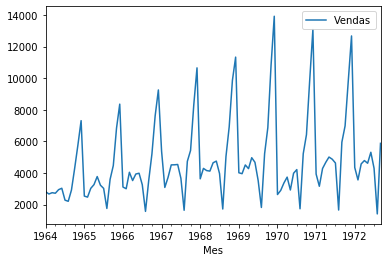

In [16]:
data.plot()

**Note aparentimente que há sazonalidade isso indica um intervalo regular em que o comportamento dos dados se repete.**

**Também temos uma tendência de alta**

## Verificação de estacionariedade

 *Uma suposição comum em muitas técnicas de séries temporais é que os dados sejam estacionários. Um processo estacionário tem a propriedade de que a média, variância e estrutura de autocorrelação não mudam no decorrer do tempo.*

<img src="https://i.imgur.com/s2tnwN9.png" />

*Utilização do modelo adfuller do Statsmodels.*

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
test_result=adfuller(data['Vendas'])

In [19]:
def adfuller_test(Vendas):
    result=adfuller(Vendas)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

* Ho: Não é estacionário
* H1: É estacionário

In [20]:
adfuller_test(data['Vendas'])

ADF Test Statistic : -1.8335930563276197
p-value : 0.3639157716602465
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Conforme teste e análise do grafico acima observamos que nosso modelo não está estacionário.**

*Vamos fazer os devidos ajuste para transformar os dados em estacionário*

## Diferenciação das colunas

*Uma das técnicas para tornar uma serie estacionaria é fazer o differencing – que consiste em subtrair valores entre tempos adjacentes da série. Desta maneira o gráfico irá representar a variação daquilo que estamos medindo.*

In [21]:
data['Diferenca_Vendas'] = data['Vendas'] - data['Vendas'].shift(1)

In [22]:
data['Vendas'].shift(1)

Mes
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Vendas, Length: 105, dtype: float64

In [23]:
adfuller_test(data['Diferenca_Vendas'].dropna())

ADF Test Statistic : -7.189896448050992
p-value : 2.5196204473871814e-10
#Lags Used : 11
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


**Conseguimos deixar o modelo estacionário**

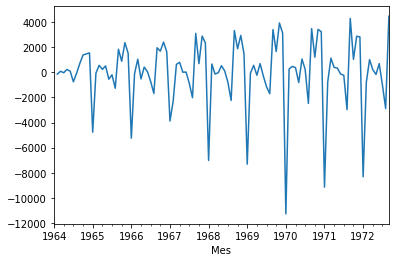

In [24]:
data['Diferenca_Vendas'].plot()

## Diferenciação Sazonal

*Agora vamos aplicar a diferenciação sazonal com shift = 12 ou seja 12 meses* 

In [27]:
data['Seasonal_First_Difference'] = data['Vendas']-data['Vendas'].shift(12)

In [28]:
data.head(15)

,Vendas,Diferenca_Vendas,Seasonal_First_Difference
Mes,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


*Repetimos o teste, agora com a Diferenciação Sazonal*

In [29]:
adfuller_test(data['Seasonal_First_Difference'].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


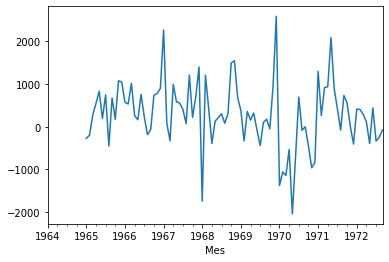

In [30]:
data['Seasonal_First_Difference'].plot()

## Modelo Auto Regressivo

 *A principal ideia dos modelos auto regressivos (AR) é que o resultado de cada ponto no futuro é função de uma regressão dos valores no passado. yt = β0+β1yt−1+ϵt. Tem como parâmetro a quantidade de pontos 'p' que serão usados na Regressão.*

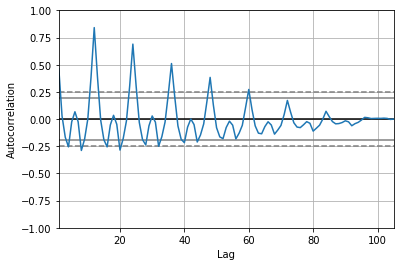

In [32]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Vendas'])
plt.show()

## ACF - Auto Correlation Function

 *O coeficiente de correlação entre dois valores em uma Time Series é chamada de Auto Correlation function (ACF). Por exemplo, o ACF de uma série temporal é dado por:*
         
        * ACF = Corr (yt , yt−k)
        * Onde: k é intervalo de tempo entre os dois valores que queremos medir.
        * O resultado do ACF é a correlação (positiva ou negativa) deste intervalo K – considerando toda a série. 
          São levados em consideração os pontos intermediários entre K.

## PACF – Partial Auto Correlation Function

*Também há o PACF – que mede a correlação de maneira análoga, mas que não leva em consideração os pontos intermediários.*

 **Considetações em relação a ACF e PACF**

* Identificação do valor de AR é normalmente feito pelo PACF.
    * Num modelo regressivo o PACF "desliga" após a janela decidida. 
    
    
* Identificação do valor de MA é normalmente feito pelo ACF.
    * Num modelo de média móvel o valor de PACF não "some", mas vai diminuindo e normalmente chega a zero. Os valores não nulos implicam em todos os intervalos que interagem com a média móvel.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

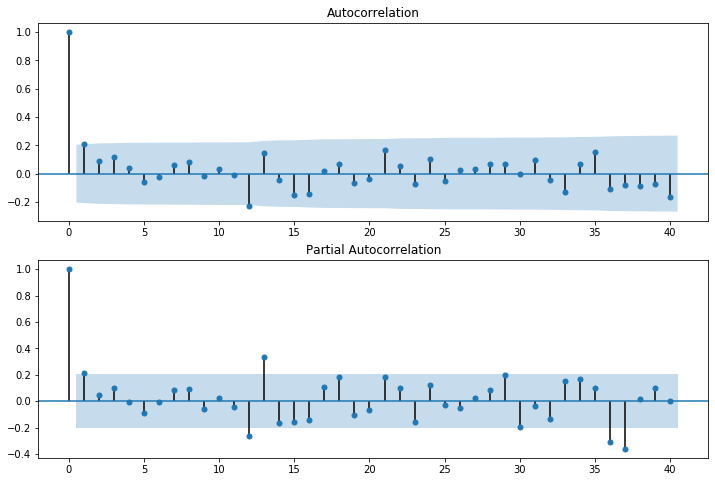

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal_First_Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal_First_Difference'].iloc[13:],lags=40,ax=ax2)

**Análisando o grafico lollipop chart nos mostra a quantidade de termos que precisaremos informar**

**Quantidade de termos em p:** olhando para o gŕafico de PACF note que apenas um ponto azul passou valor crítico (faixa azulada horizontal) antes de retornarem para dentro da faixa. 

**Quantidade de termos em q:** olhando para o gŕafico de ACF note que apenas um ponto azul passou valor crítico (faixa azulada horizontal) antes de retornarem para dentro da faixa.

# ARIMA

<img src="https://i.imgur.com/4m8LSga.png" />

**Modelo ARIMA (AR+ Integrated + MA)**

**Terminologias em ARIMA**

O modelo ARIMA pode ser basicamente resumido por três fatores:

**p** = o número de termos autorregressivos.

* p é o número de termos auto-regressivos (parte AR). Permite incorporar o efeito de valores passados em nosso modelo. Intuitivamente, isso seria semelhante ao afirmar que é provável que esteja quente amanhã se estiver quente nos últimos três dias.

**d** = o número é o fator que vamos aplicar para resolver a estacionaridade.

* d é o número de diferenças não sazonais necessárias para a estacionariedade. Intuitivamente, isso seria semelhante ao afirmar que provavelmente haverá a mesma temperatura amanhã se a diferença de temperatura nos últimos três dias tiver sido muito pequena.

**q** = o número de termos da média móvel.

* q é o número de erros de previsão atrasados na equação de previsão (parte MA). Isso nos permite definir o erro do nosso modelo como uma combinação linear dos valores de erro observados em momentos anteriores no passado.

Estes são os três números inteiros (p, d, q) usados para parametrizar os modelos ARIMA. Portanto, isso é chamado de modelo “ARIMA (p, d, q)”.

In [37]:
from statsmodels.tsa.arima_model import ARIMA

*Ok, para dados não sazonais usaremos:*
    
**p=1, d=1, q=1**

In [40]:
model=ARIMA(data['Vendas'],order=(1,1,1))
model_fit=model.fit()

In [41]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Vendas   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.263
Date:                Tue, 18 Aug 2020   AIC                           1910.251
Time:                        15:22:03   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.7841     12.405      1.837      0.066      -1.530      47.098
ar.L1.D.Vendas     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Vendas    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

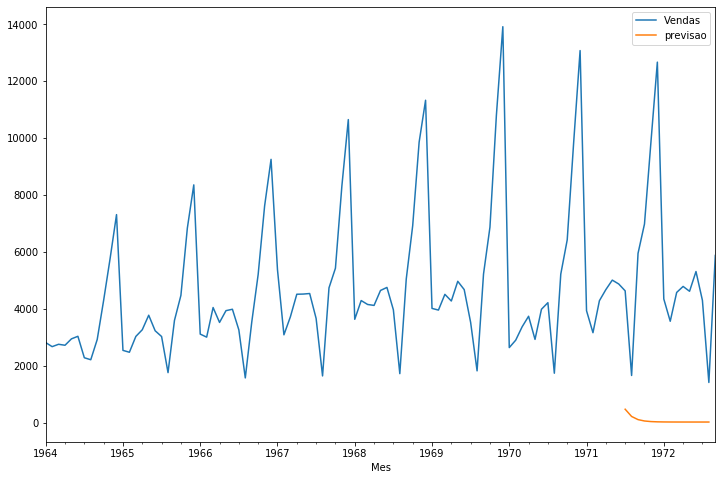

In [44]:
data['previsao']=model_fit.predict(start=90,end=103,dynamic=True)
data[['Vendas','previsao']].plot(figsize=(12,8))

**Pronto treinamos nosso modelo, agora estamos prontos para para fazer uma previsão**

## SARIMA – (Seasonal + ARIMA)

*O SARIMA consegue tratar séries sazonais e não estacionárias e possui o parâmetro 's' que indica em quanto tempo a série se repete, a sazonalidade se manifesta.*

In [46]:
import statsmodels.api as sm

### Mas para esse modelo iremos usar o SARIMAX

*De maneira análoga o SARIMAX funciona como o SARIMA e possui a capacidade de tratar e considerar em suas predições variáveis explanatórias.*

In [48]:
model=sm.tsa.statespace.SARIMAX(data['Vendas'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

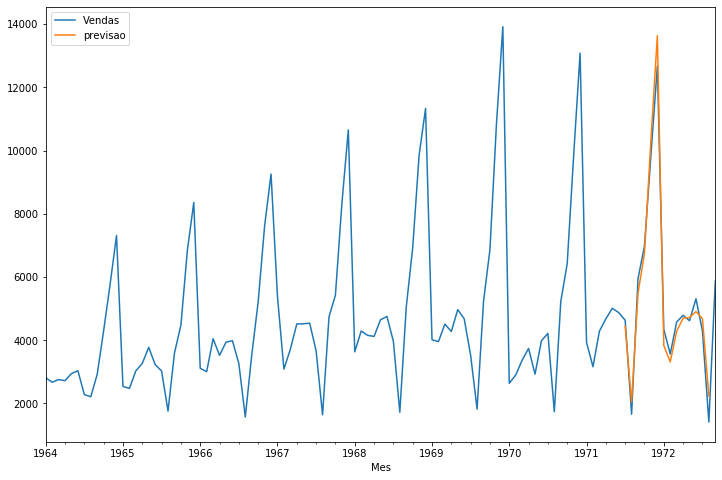

In [50]:
data['previsao']=results.predict(start=90,end=103,dynamic=True)
data[['Vendas','previsao']].plot(figsize=(12,8))

*Em nossa previsão de teste note que a linha laranja fica muito próxima da azul( que são valores reais), isso significa que nosso modelo está bem ajustado*

# Previsão

*Agora vamos fazer um previsão para o próximo ano*

In [52]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [53]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [54]:
future_datest_df.tail()

,Vendas,Diferenca_Vendas,Seasonal_First_Difference,previsao
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [55]:
future_df=pd.concat([data,future_datest_df])

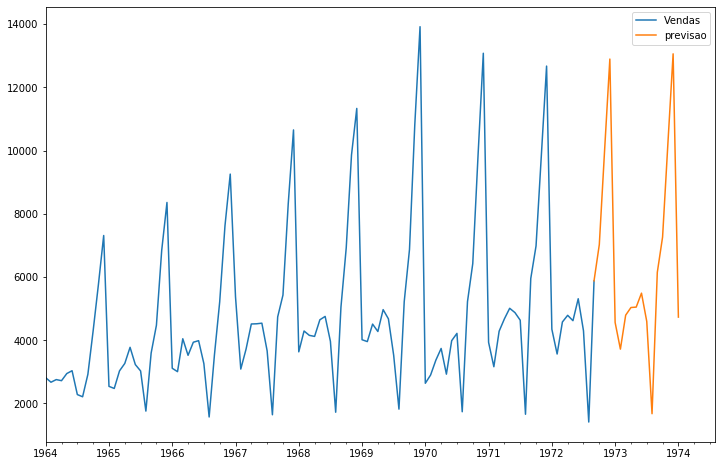

In [56]:
future_df['previsao'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Vendas', 'previsao']].plot(figsize=(12, 8))

Aqui está a previsão de vendas de vinhos para o próximo ano \o/